In [1]:
import numpy as np
import scanpy as sc
import torch

import matplotlib.pyplot as plt
from scarches.dataset.trvae.data_handling import remove_sparsity
from tranvae.model import TRANVAE
from sklearn.metrics import classification_report

sc.settings.set_figure_params(dpi=200, frameon=False)
sc.set_figure_params(dpi=200)
torch.set_printoptions(precision=3, sci_mode=False, edgeitems=7)

In [2]:
unlabeled_strat = "batch"
cells_per_ct = 2000

# Model Params
latent_dim = 10
use_mmd = False

# Training Params
alpha_epoch_anneal = 1e6
eta = 1
tau = 0
clustering_res = 2
labeled_loss_metric = "dist"
unlabeled_loss_metric = "dist"
class_metric = "dist"

early_stopping_kwargs = {
    "early_stopping_metric": "val_classifier_loss",
    "mode": "min",
    "threshold": 0,
    "patience": 20,
    "reduce_lr": True,
    "lr_patience": 13,
    "lr_factor": 0.1,
}

cell_type_key = ["cell_type"]

In [3]:
DATA_DIR = '../data'
adata = sc.read(
    f'{DATA_DIR}/benchmark_pancreas_shrinked.h5ad'
)
condition_key = 'study'
reference = ["inDrop1", "inDrop2", "inDrop3", "inDrop4", "fluidigmc1", "smartseq2", "smarter"]
query = ["celseq", "celseq2"]
adata.obs['query'] = adata.obs['study'].isin(query).astype('category')

In [8]:
source_adata = adata[adata.obs.study.isin(reference)].copy()
target_adata = adata[adata.obs.study.isin(query)].copy()

In [4]:
adata = remove_sparsity(adata)

indices = np.arange(len(adata))
#stratified label/unlabeled split
if unlabeled_strat == "batch":
    labeled_ind = indices[adata.obs.study.isin(reference)].tolist()
    labeled_adata = adata[adata.obs.study.isin(reference)].copy()
    unlabeled_adata = adata[adata.obs.study.isin(query)].copy()
if unlabeled_strat == "ct":
    labeled_ind = []
    cts = adata.obs[cell_type_key[0]].unique().tolist()
    for celltype in cts:
        ct_indices = indices[adata.obs[cell_type_key[0]].isin([celltype])]
        ct_sel_ind = np.random.choice(ct_indices, size=cells_per_ct, replace=False)
        labeled_ind += ct_sel_ind.tolist()
        print(celltype, len(ct_indices), len(ct_sel_ind), len(labeled_ind))
    unlabeled_ind = np.delete(indices, labeled_ind).tolist()
    labeled_adata = adata[labeled_ind].copy()
    unlabeled_adata = adata[unlabeled_ind].copy()

In [10]:
tranvae = TRANVAE(
    adata=source_adata,
    condition_key=condition_key,
    cell_type_keys=cell_type_key,
    hidden_layer_sizes=[128, 128],
    latent_dim=latent_dim,
    use_mmd=use_mmd,
)


INITIALIZING NEW NETWORK..............
Encoder Architecture:
	Input Layer in, out and cond: 4000 128 7
	Hidden Layer 1 in/out: 128 128
	Mean/Var Layer in/out: 128 10
Decoder Architecture:
	First Layer in, out and cond:  10 128 7
	Hidden Layer 1 in/out: 128 128
	Output Layer in/out:  128 4000 



In [11]:
tranvae.train(
    n_epochs=500,
    early_stopping_kwargs=early_stopping_kwargs,
    pretraining_epochs=100,
    alpha_epoch_anneal=alpha_epoch_anneal,
    eta=eta,
    tau=tau,
    clustering_res=clustering_res,
    labeled_loss_metric=labeled_loss_metric,
    unlabeled_loss_metric=unlabeled_loss_metric
)

 |██████--------------| 33.4%  - val_loss: 997.2001287287 - val_trvae_loss: 996.6991355202 - val_classifier_loss: 0.5009942840 - val_labeled_loss: 0.500994284030
ADJUSTED LR
 |█████████-----------| 47.8%  - val_loss: 998.2086514560 - val_trvae_loss: 997.8311712092 - val_classifier_loss: 0.3774847009 - val_labeled_loss: 0.377484700990
ADJUSTED LR
 |█████████-----------| 49.2%  - val_loss: 996.6827281605 - val_trvae_loss: 996.3005038175 - val_classifier_loss: 0.3822212382 - val_labeled_loss: 0.3822212382
Stopping early: no improvement of more than 0 nats in 20 epochs
If the early stopping criterion is too strong, please instantiate it with different parameters in the train method.
Saving best state of network...
Best State was in Epoch 224


In [62]:
ref_path = f'../pr/ref_model'
tranvae.save(ref_path, overwrite=True)

In [52]:
data_latent = tranvae.get_latent()
adata_latent = sc.AnnData(data_latent)
adata_latent.obs[condition_key] = source_adata.obs[condition_key].tolist()
adata_latent.obs['cell_type'] = source_adata.obs['cell_type'].tolist()

In [53]:
landmarks = tranvae.get_landmarks_info()
full_latent = adata_latent.concatenate(landmarks, batch_key=None)

In [54]:
sc.pp.neighbors(adata_latent)
sc.tl.leiden(adata_latent)
sc.tl.umap(adata_latent)

[<AxesSubplot:title={'center':'study'}, xlabel='UMAP1', ylabel='UMAP2'>,
 <AxesSubplot:title={'center':'cell_type'}, xlabel='UMAP1', ylabel='UMAP2'>]

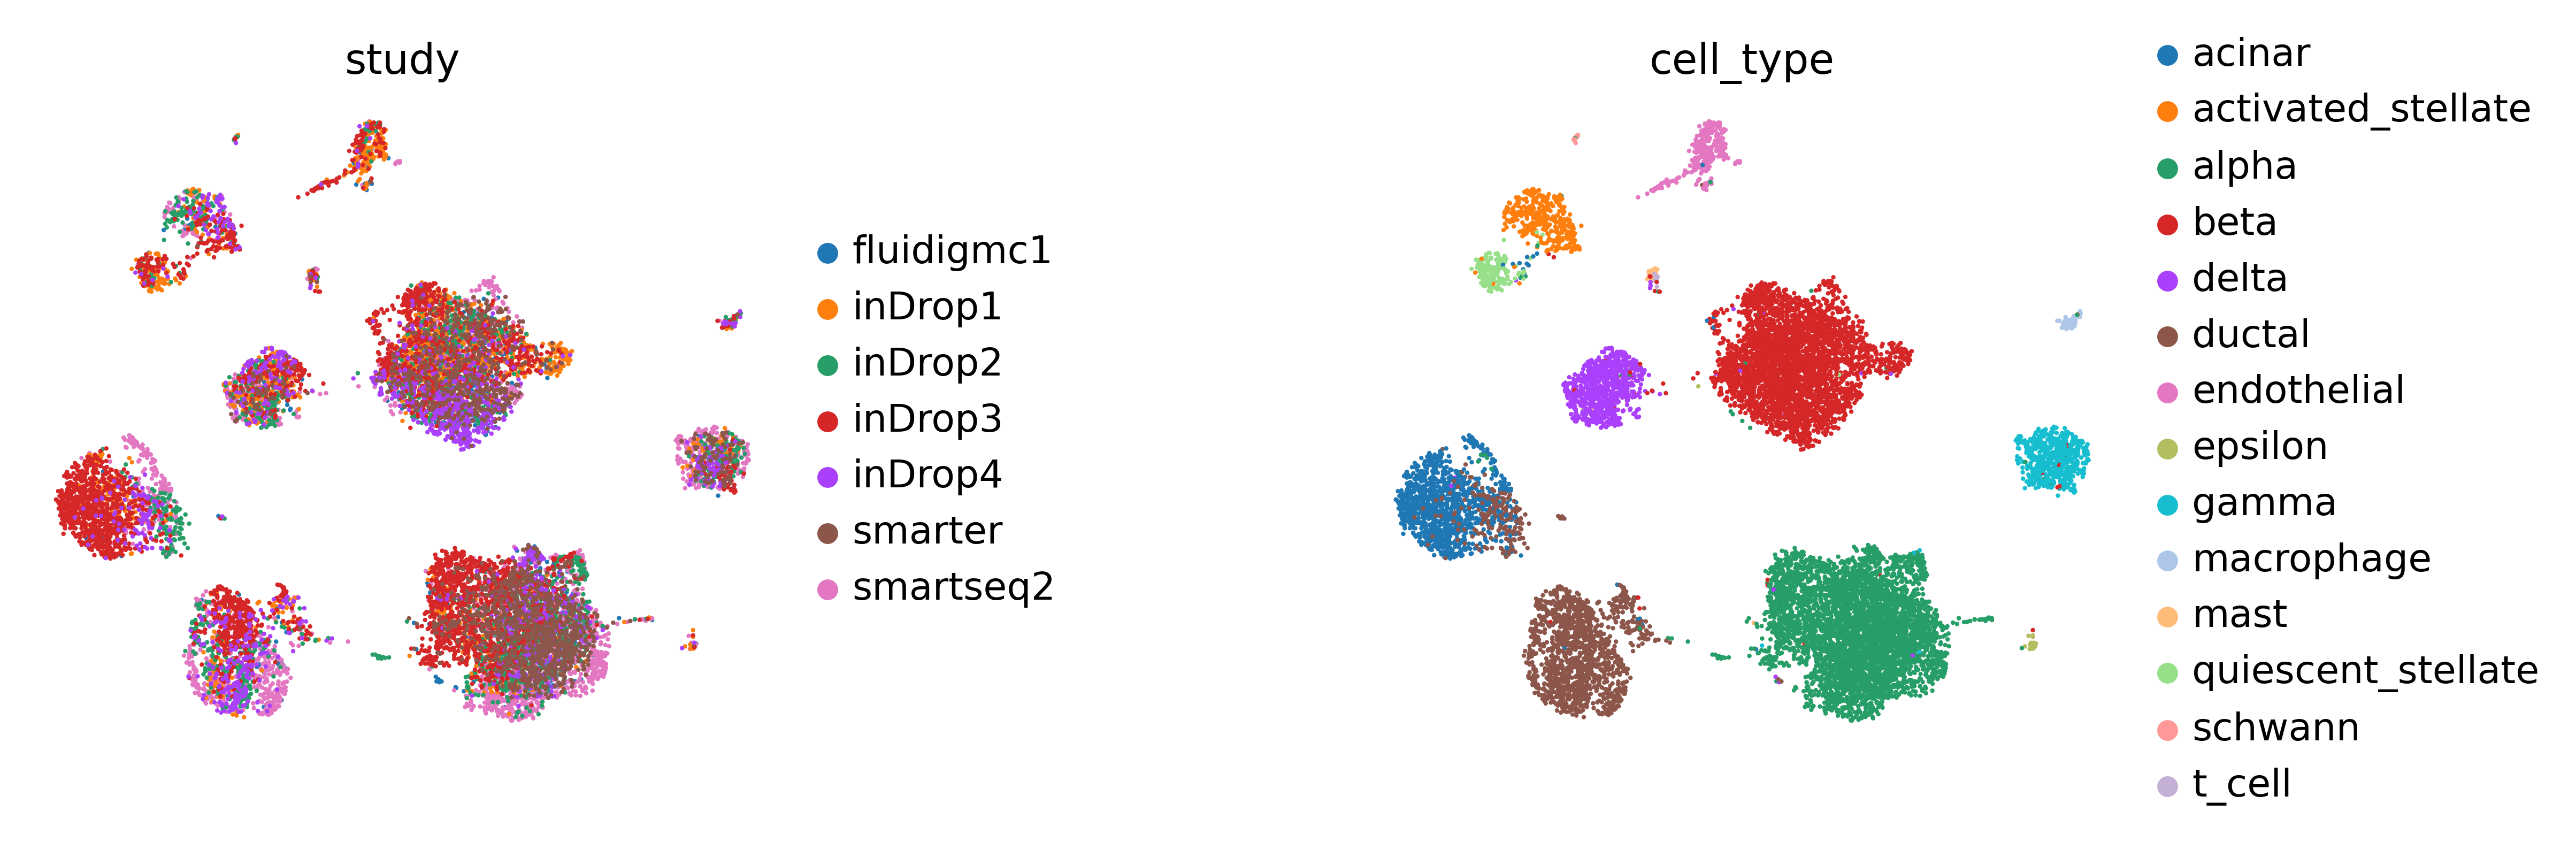

In [56]:
sc.pl.umap(adata_latent,
           color=['study', 'cell_type'],
           frameon=False,
           wspace=0.6,
           show=False
           )


In [57]:
full_latent.obs.study.unique()

array(['fluidigmc1', 'smartseq2', 'inDrop1', 'inDrop2', 'inDrop3',
       'inDrop4', 'smarter', 'Landmark-Set Labeled'], dtype=object)

Trying to set attribute `.uns` of view, copying.


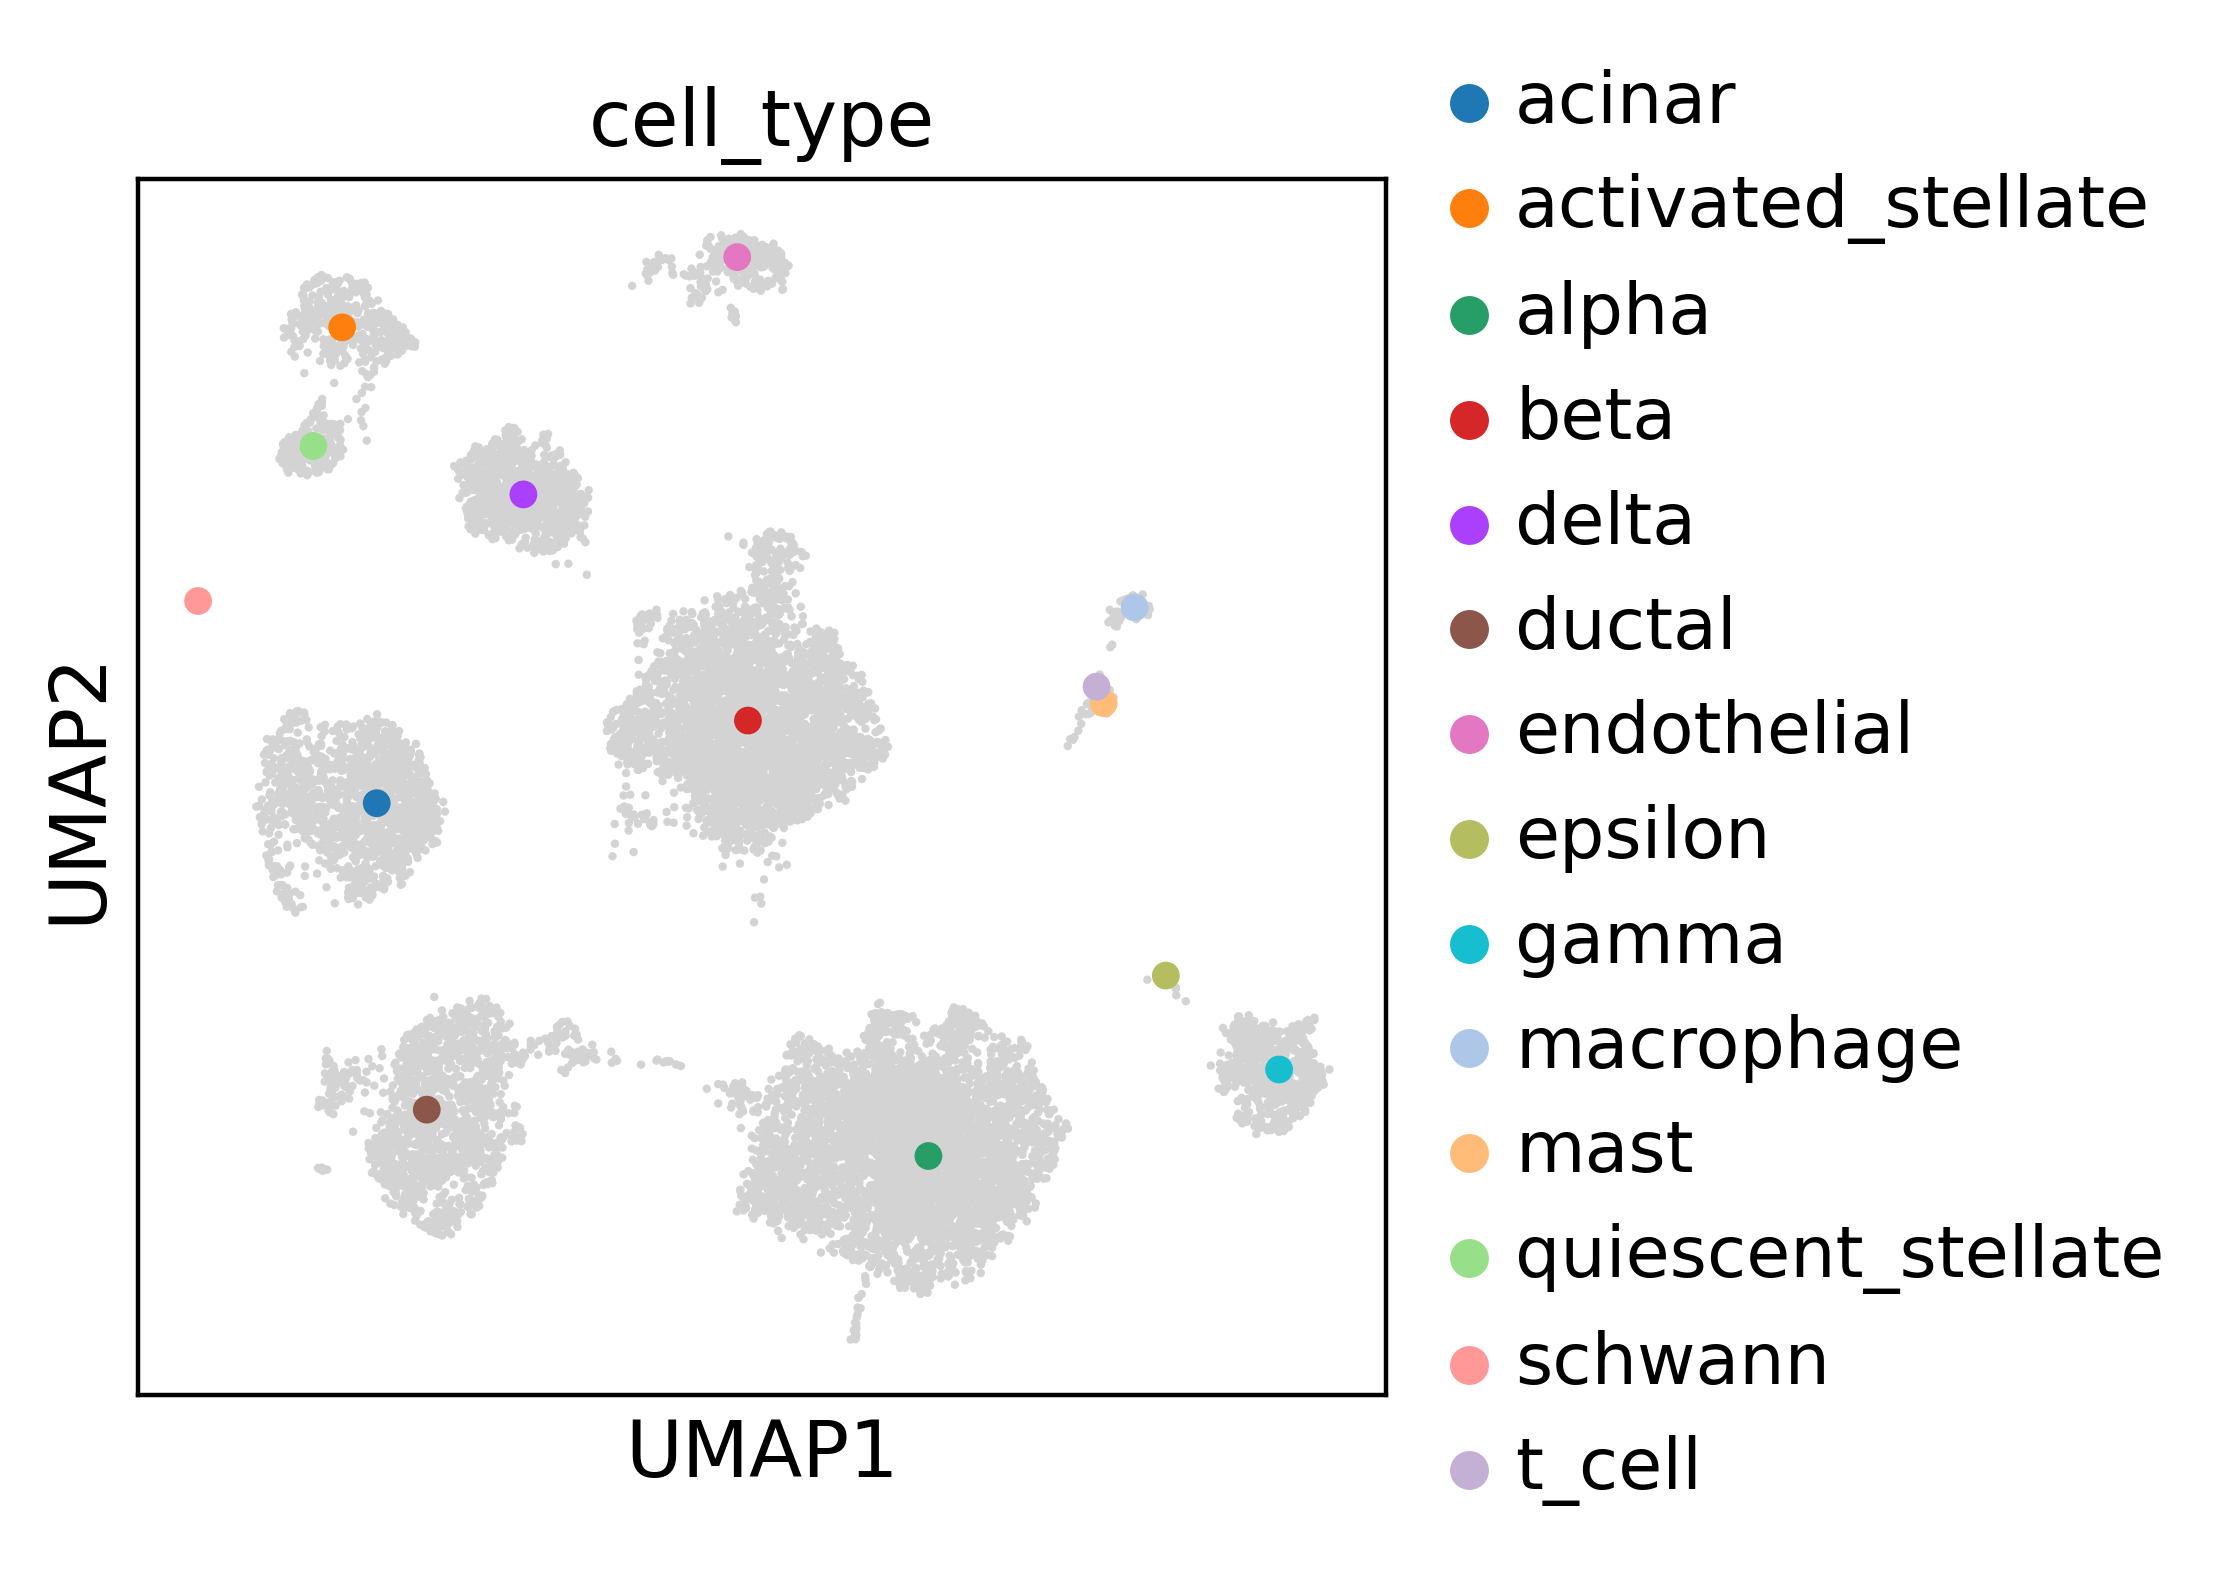

In [59]:
fig, ax = plt.subplots(1, 1)
sc.pp.neighbors(full_latent)
sc.tl.umap(full_latent)

Trying to set attribute `.uns` of view, copying.


Text(0.5, 1.0, 'Landmarks')

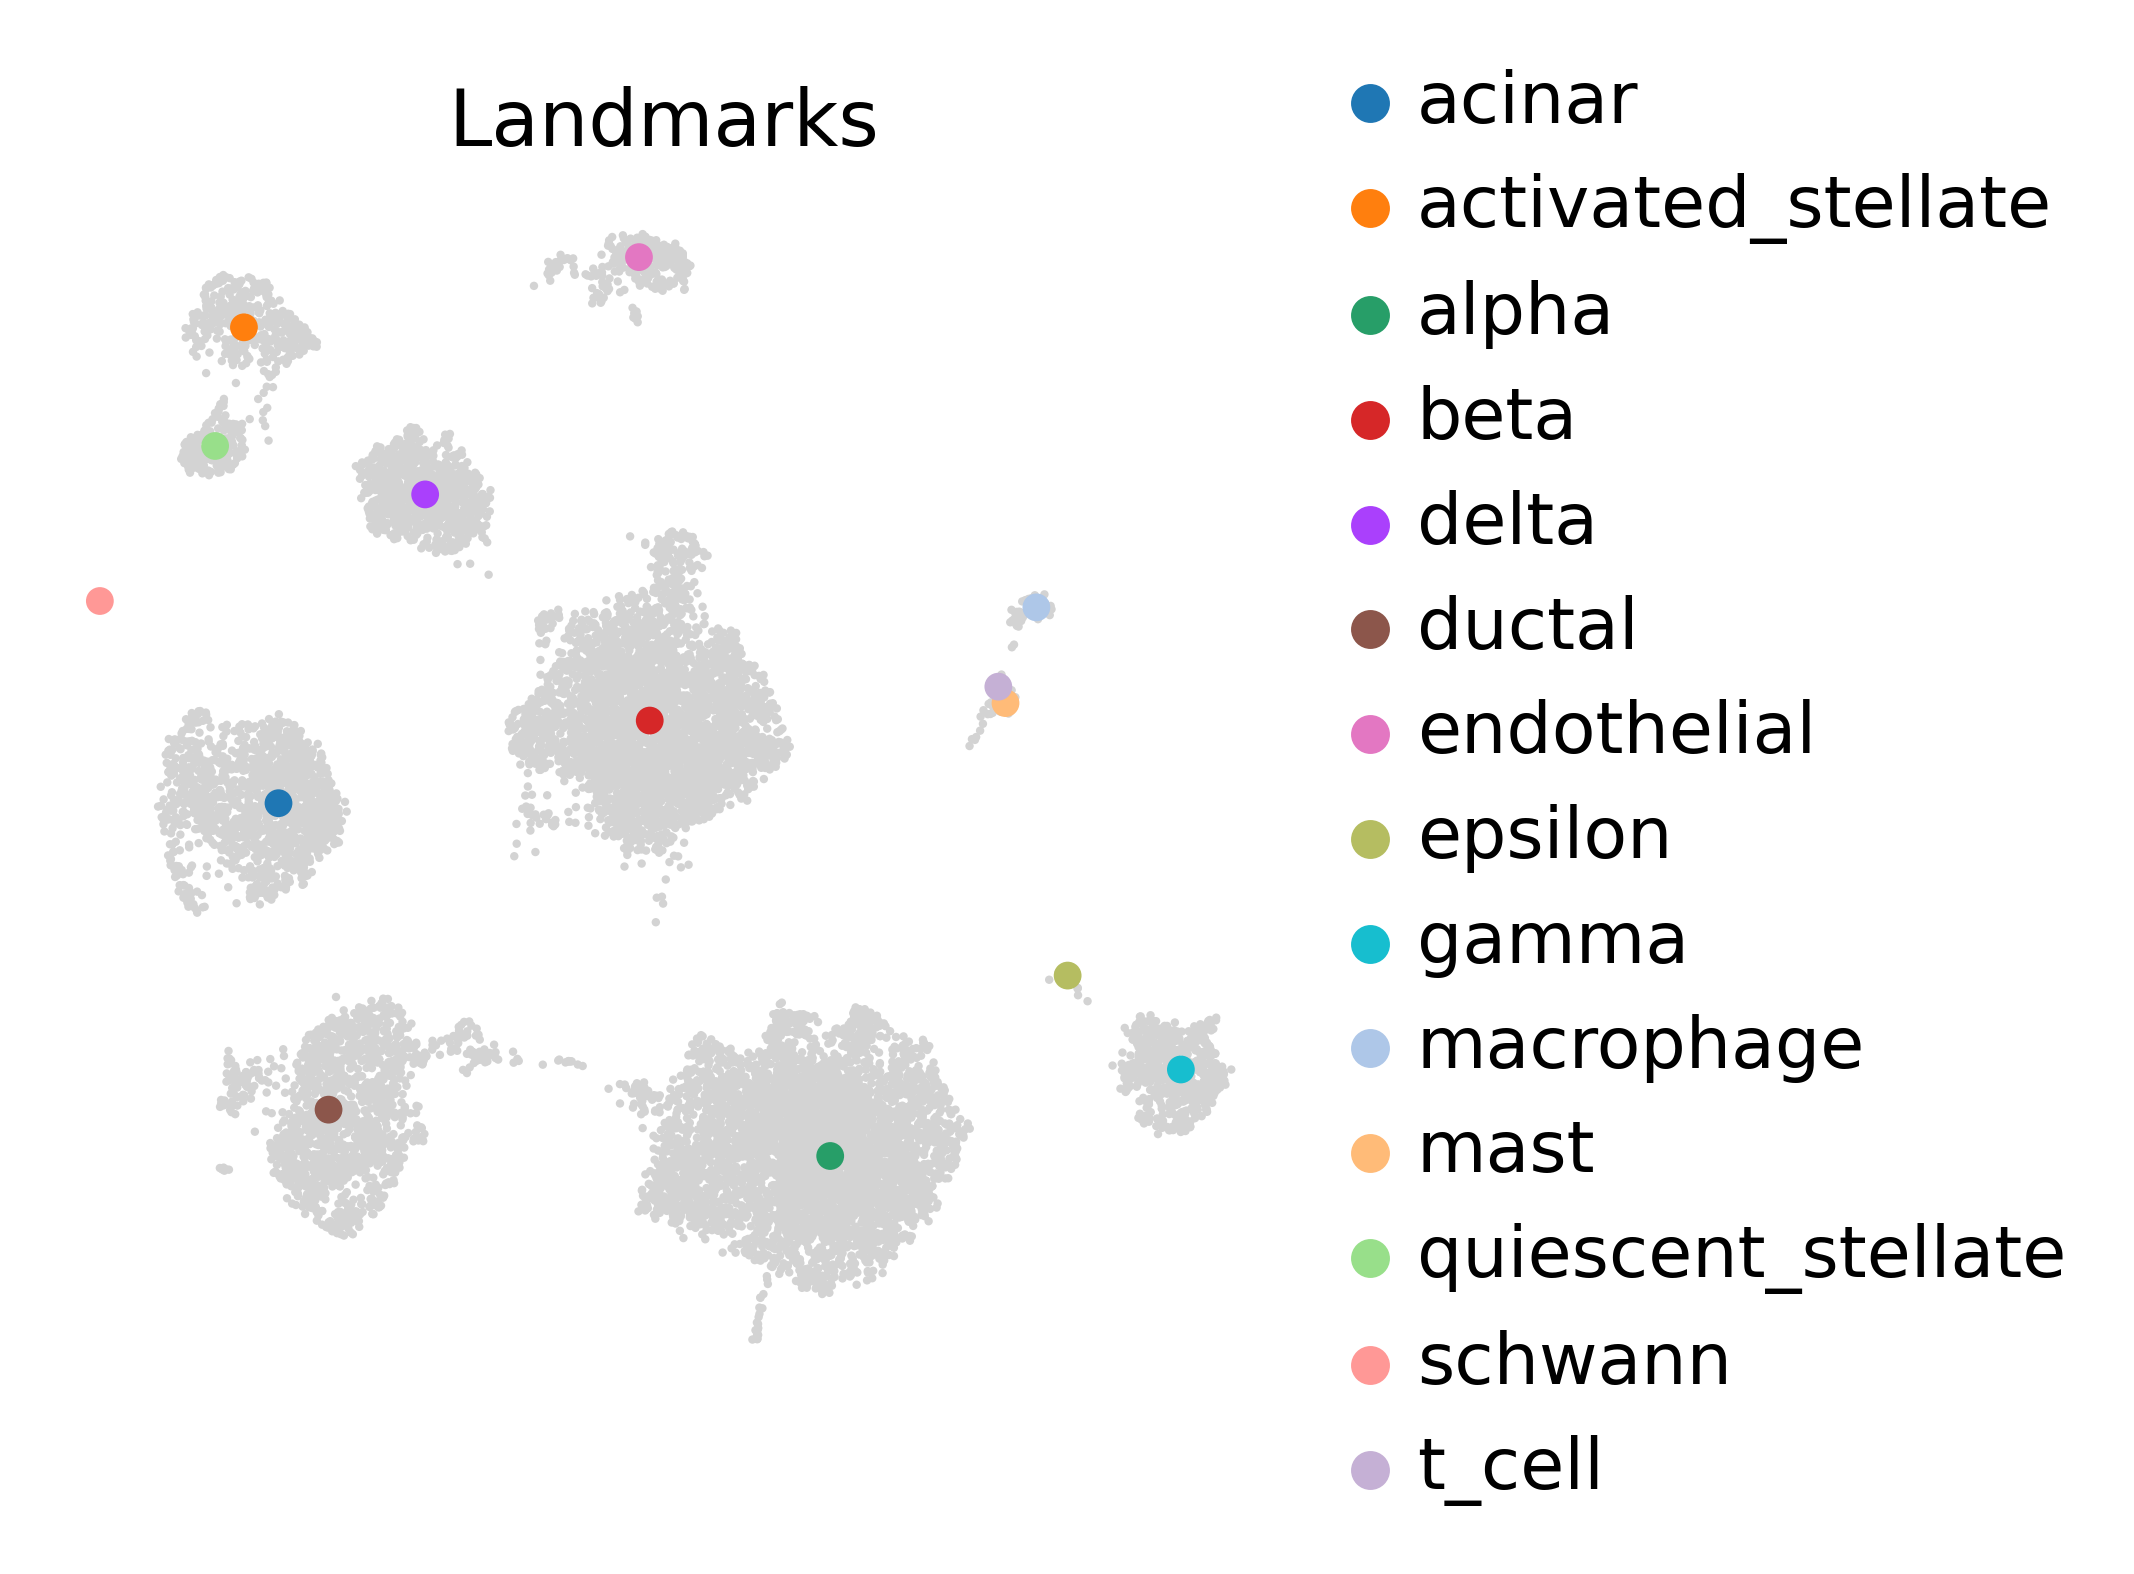

In [61]:
fig, ax = plt.subplots(1, 1)
sc.pl.umap(full_latent, ax=ax, show=False)
sc.pl.umap(
    full_latent[full_latent.obs[condition_key].str.contains('Landmark')],
    size=100,
    color='cell_type',
    ax=ax,
    frameon=False,
    show=False
)
ax.set_title('Landmarks')

In [28]:
sc.pp.neighbors(adata)
sc.tl.leiden(adata)
sc.tl.umap(adata)

         Falling back to preprocessing with `sc.pp.pca` and default params.


[<AxesSubplot:title={'center':'study'}, xlabel='UMAP1', ylabel='UMAP2'>,
 <AxesSubplot:title={'center':'query'}, xlabel='UMAP1', ylabel='UMAP2'>]

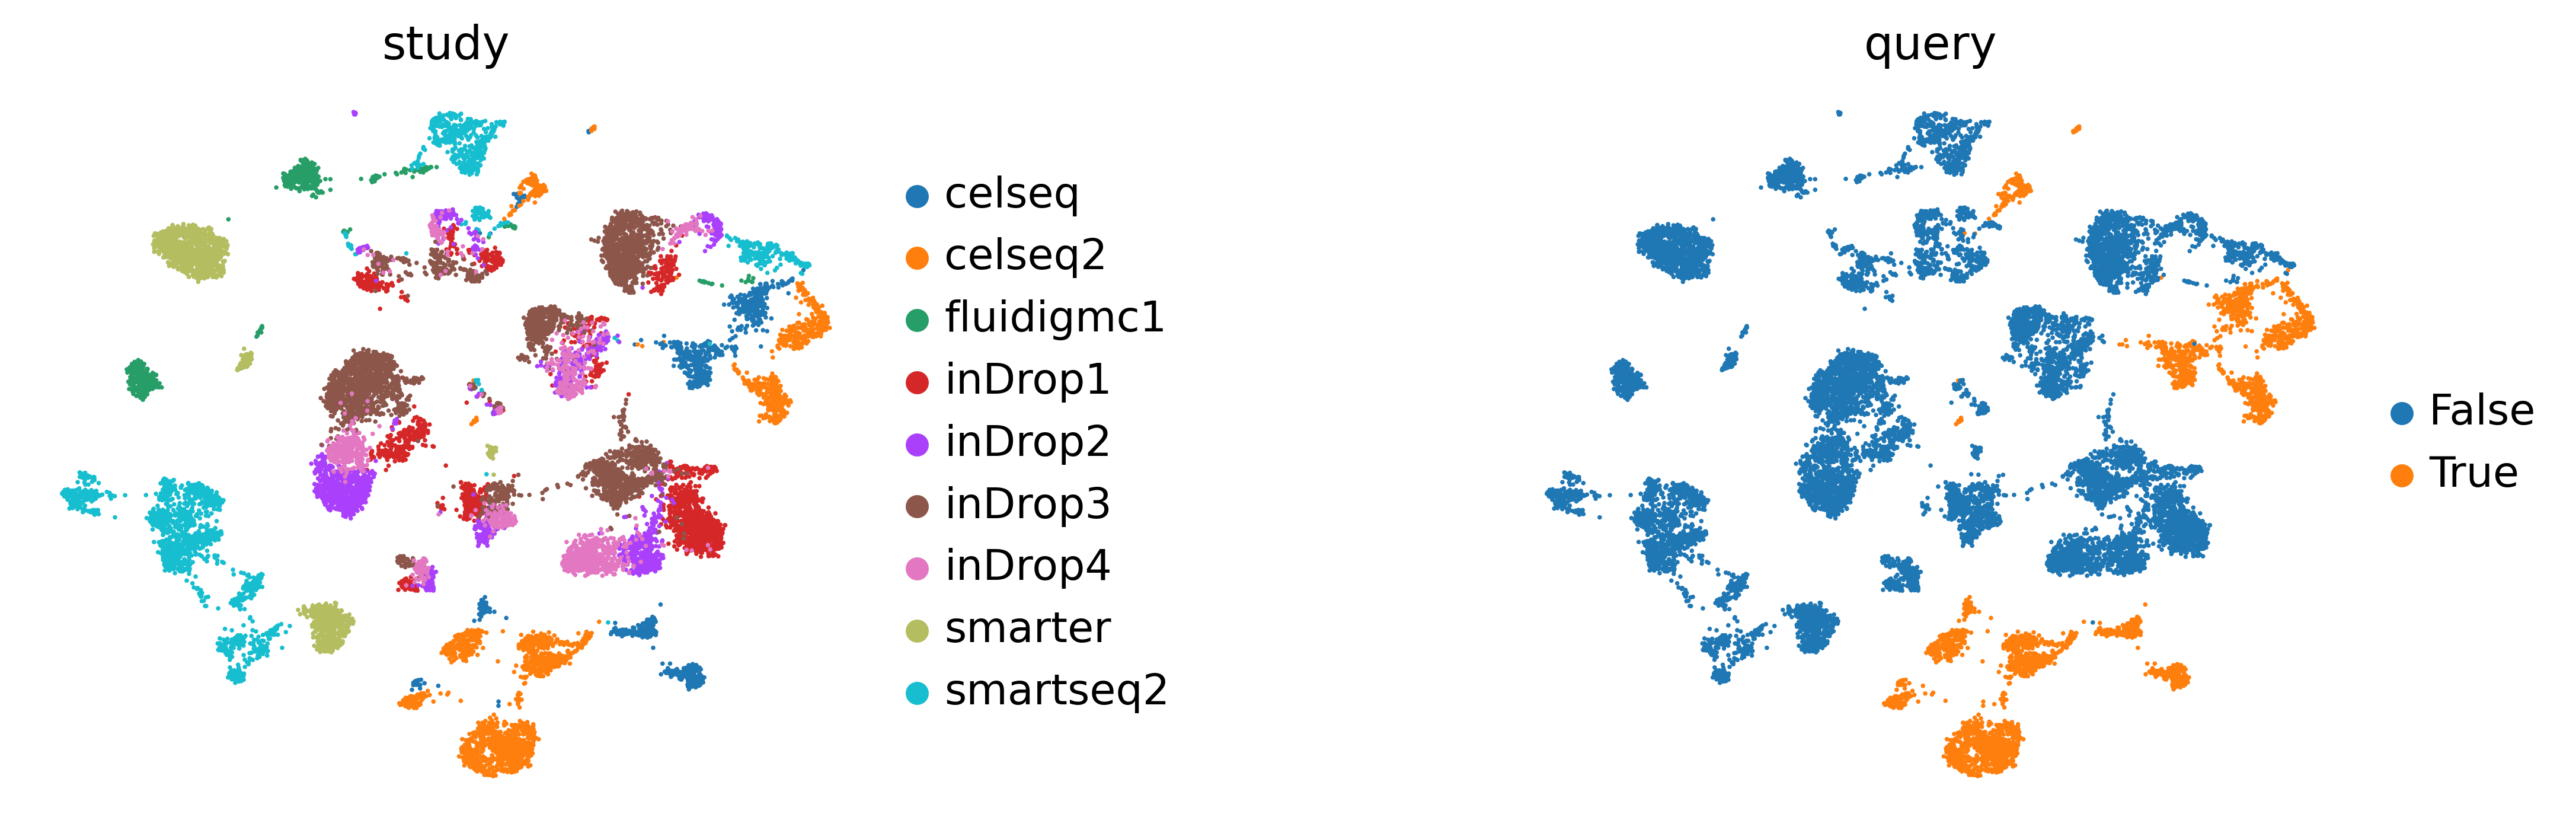

In [32]:
sc.pl.umap(adata,
           color=['study', 'query'],
           frameon=False,
           wspace=0.6,
           show=False
           )

In [63]:
tranvae = TRANVAE.load_query_data(
    adata=target_adata,
    reference_model=f'../pr/ref_model',
    labeled_indices=[],
)

AnnData object with n_obs × n_vars = 3289 × 4000
    obs: 'study', 'cell_type', 'trvae_size_factors', 'trvae_labeled'

INITIALIZING NEW NETWORK..............
Encoder Architecture:
	Input Layer in, out and cond: 4000 128 9
	Hidden Layer 1 in/out: 128 128
	Mean/Var Layer in/out: 128 10
Decoder Architecture:
	First Layer in, out and cond:  10 128 9
	Hidden Layer 1 in/out: 128 128
	Output Layer in/out:  128 4000 



In [65]:
tranvae.train(
    n_epochs=500,
    early_stopping_kwargs=early_stopping_kwargs,
    pretraining_epochs=100,
    eta=eta,
    tau=tau,
    weight_decay=0,
    clustering_res=clustering_res,
    labeled_loss_metric=labeled_loss_metric,
    unlabeled_loss_metric=unlabeled_loss_metric
)

 |████----------------| 20.0%  - val_loss: 1414.1013183594 - val_trvae_loss: 1414.1013183594
Initializing unlabeled landmarks with Leiden-Clustering with an unknown number of clusters.
Leiden Clustering succesful. Found 22 clusters.
 |█████---------------| 29.6%  - val_loss: 1391.1880696615 - val_trvae_loss: 1391.1880696615 - val_classifier_loss: 0.0000295199 - val_unlabeled_loss: 0.0295199125
ADJUSTED LR
 |██████--------------| 31.0%  - val_loss: 1383.0952962240 - val_trvae_loss: 1383.0952962240 - val_classifier_loss: 0.0000304441 - val_unlabeled_loss: 0.0304441359
Stopping early: no improvement of more than 0 nats in 20 epochs
If the early stopping criterion is too strong, please instantiate it with different parameters in the train method.
Saving best state of network...
Best State was in Epoch 133


In [76]:
data_latent = tranvae.get_latent(
    x=adata.X,
    c=adata.obs[condition_key]
)

In [91]:
adata_latent_wquery = sc.AnnData(data_latent)
adata_latent_wquery.obs[condition_key] = adata.obs[condition_key].tolist()
adata_latent_wquery.obs['cell_type'] = adata_latent_wquery.obs['cell_type'].tolist()

In [92]:
sc.pp.neighbors(adata_latent_wquery)
sc.tl.leiden(adata_latent_wquery)
sc.tl.umap(adata_latent_wquery)

... storing 'query' as categorical


[<AxesSubplot:title={'center':'study'}, xlabel='UMAP1', ylabel='UMAP2'>,
 <AxesSubplot:title={'center':'query'}, xlabel='UMAP1', ylabel='UMAP2'>]

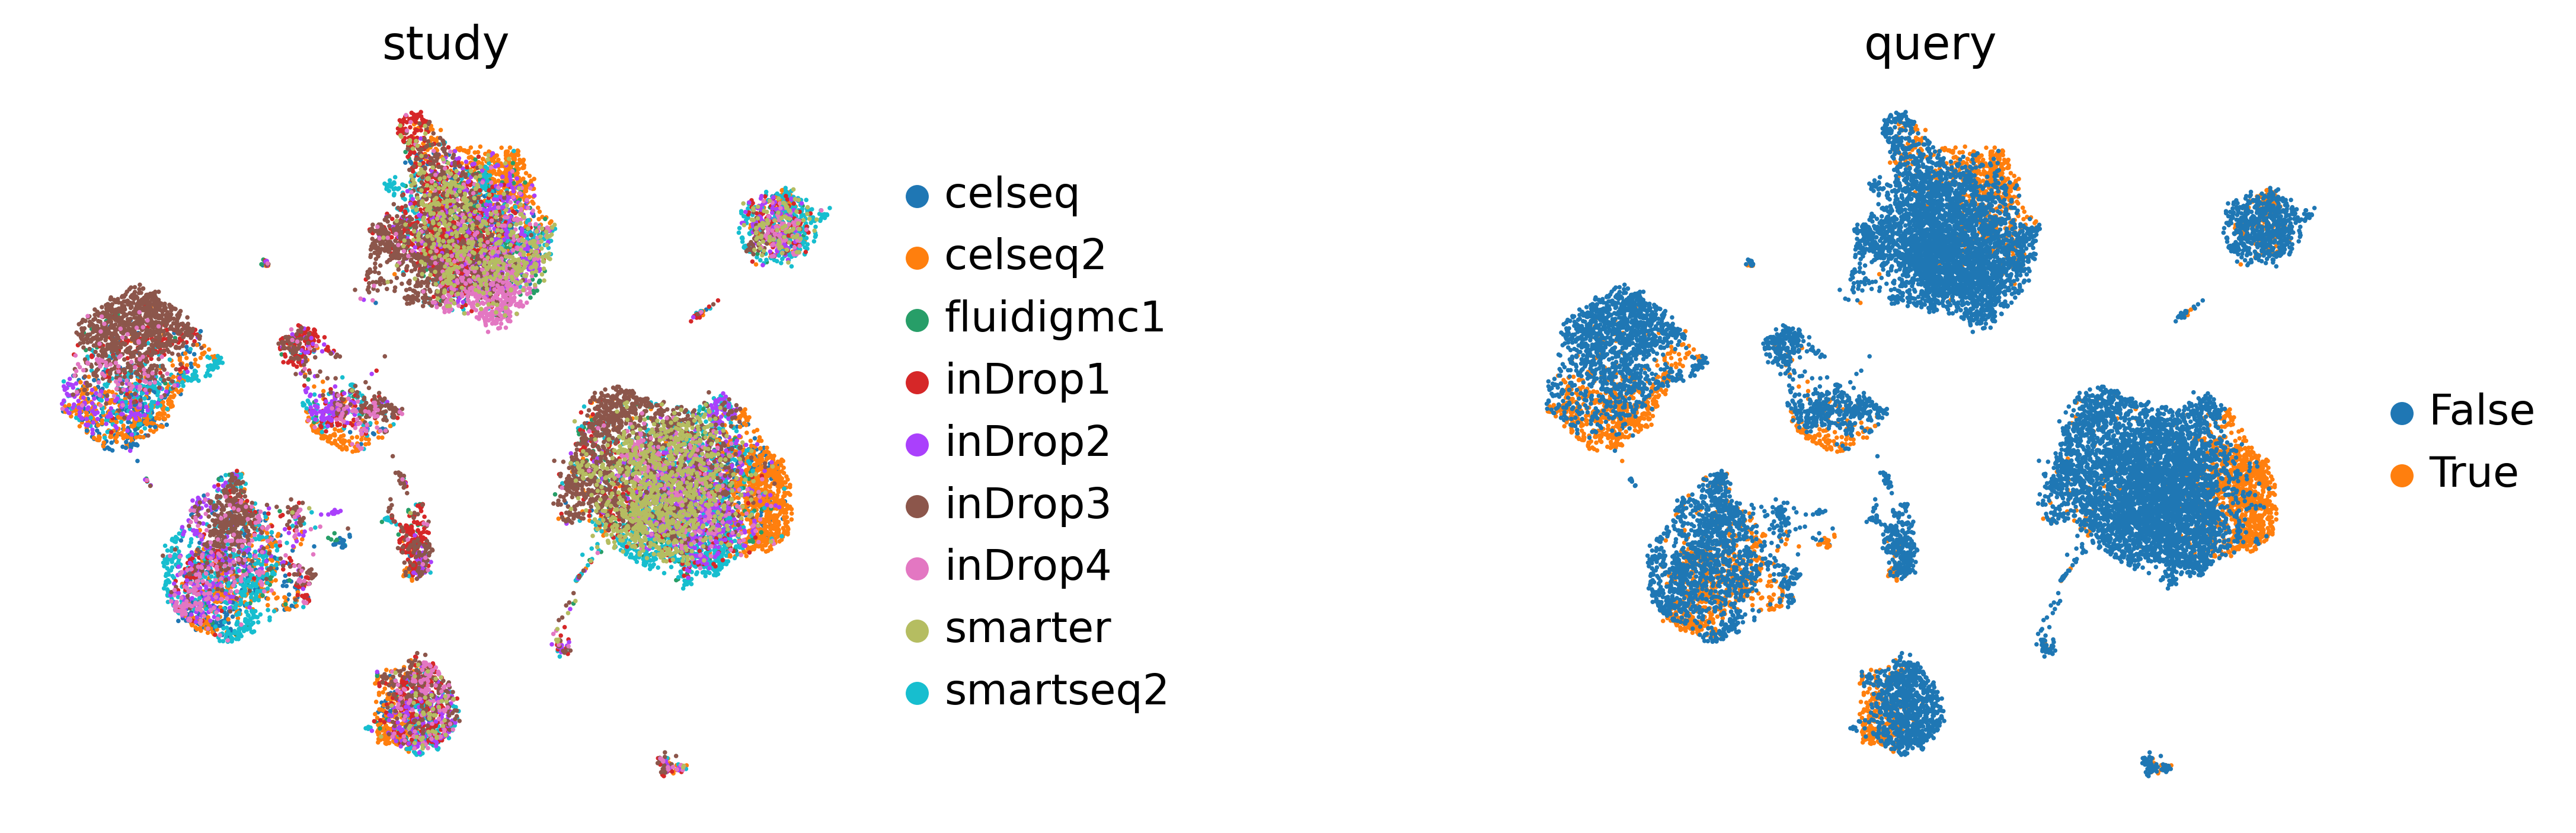

In [96]:
sc.pl.umap(adata_latent_wquery,
           color=['study', 'query'],
           frameon=False,
           wspace=0.6,
           show=False
           )

In [111]:
results_dict = tranvae.classify(adata.X, adata.obs[condition_key], metric=class_metric)
for i in range(len(cell_type_key)):
    preds = results_dict[cell_type_key[i]]['preds']
    probs = results_dict[cell_type_key[i]]['probs']
    results_dict[cell_type_key[i]]['report'] = classification_report(
        y_true=adata.obs[cell_type_key[i]], 
        y_pred=preds,
        output_dict=True
    )

    correct_probs = probs[preds == adata.obs[cell_type_key[i]]]
    incorrect_probs = probs[preds != adata.obs[cell_type_key[i]]]
    data = [correct_probs, incorrect_probs]

    checks = np.array(len(adata) * ['incorrect'])
    checks[preds == adata.obs[cell_type_key[i]]] = 'correct'
    adata_latent_wquery.obs[cell_type_key[i]] = adata.obs[cell_type_key[i]].tolist()
    adata_latent_wquery.obs[f'{cell_type_key[i]}_pred'] = preds.tolist()
    adata_latent_wquery.obs[f'{cell_type_key[i]}_bool'] = checks.tolist()

In [112]:
results_dict['cell_type']['report']

{'acinar': {'precision': 0.888402625820569,
  'recall': 0.9730377471539844,
  'f1-score': 0.9287961109522448,
  'support': 1669},
 'activated_stellate': {'precision': 0.9660297239915074,
  'recall': 0.9806034482758621,
  'f1-score': 0.9732620320855615,
  'support': 464},
 'alpha': {'precision': 0.9979591836734694,
  'recall': 0.9792463134898962,
  'f1-score': 0.9885141964531838,
  'support': 5493},
 'beta': {'precision': 0.989410348977136,
  'recall': 0.9860877908371312,
  'f1-score': 0.9877462758289283,
  'support': 4169},
 'delta': {'precision': 0.9642521166509878,
  'recall': 0.9715639810426541,
  'f1-score': 0.9678942398489141,
  'support': 1055},
 'ductal': {'precision': 0.9804118533400301,
  'recall': 0.911297852474323,
  'f1-score': 0.9445923058311153,
  'support': 2142},
 'endothelial': {'precision': 0.9684542586750788,
  'recall': 0.9808306709265175,
  'f1-score': 0.9746031746031746,
  'support': 313},
 'epsilon': {'precision': 0.5576923076923077,
  'recall': 0.90625,
  'f1-sc

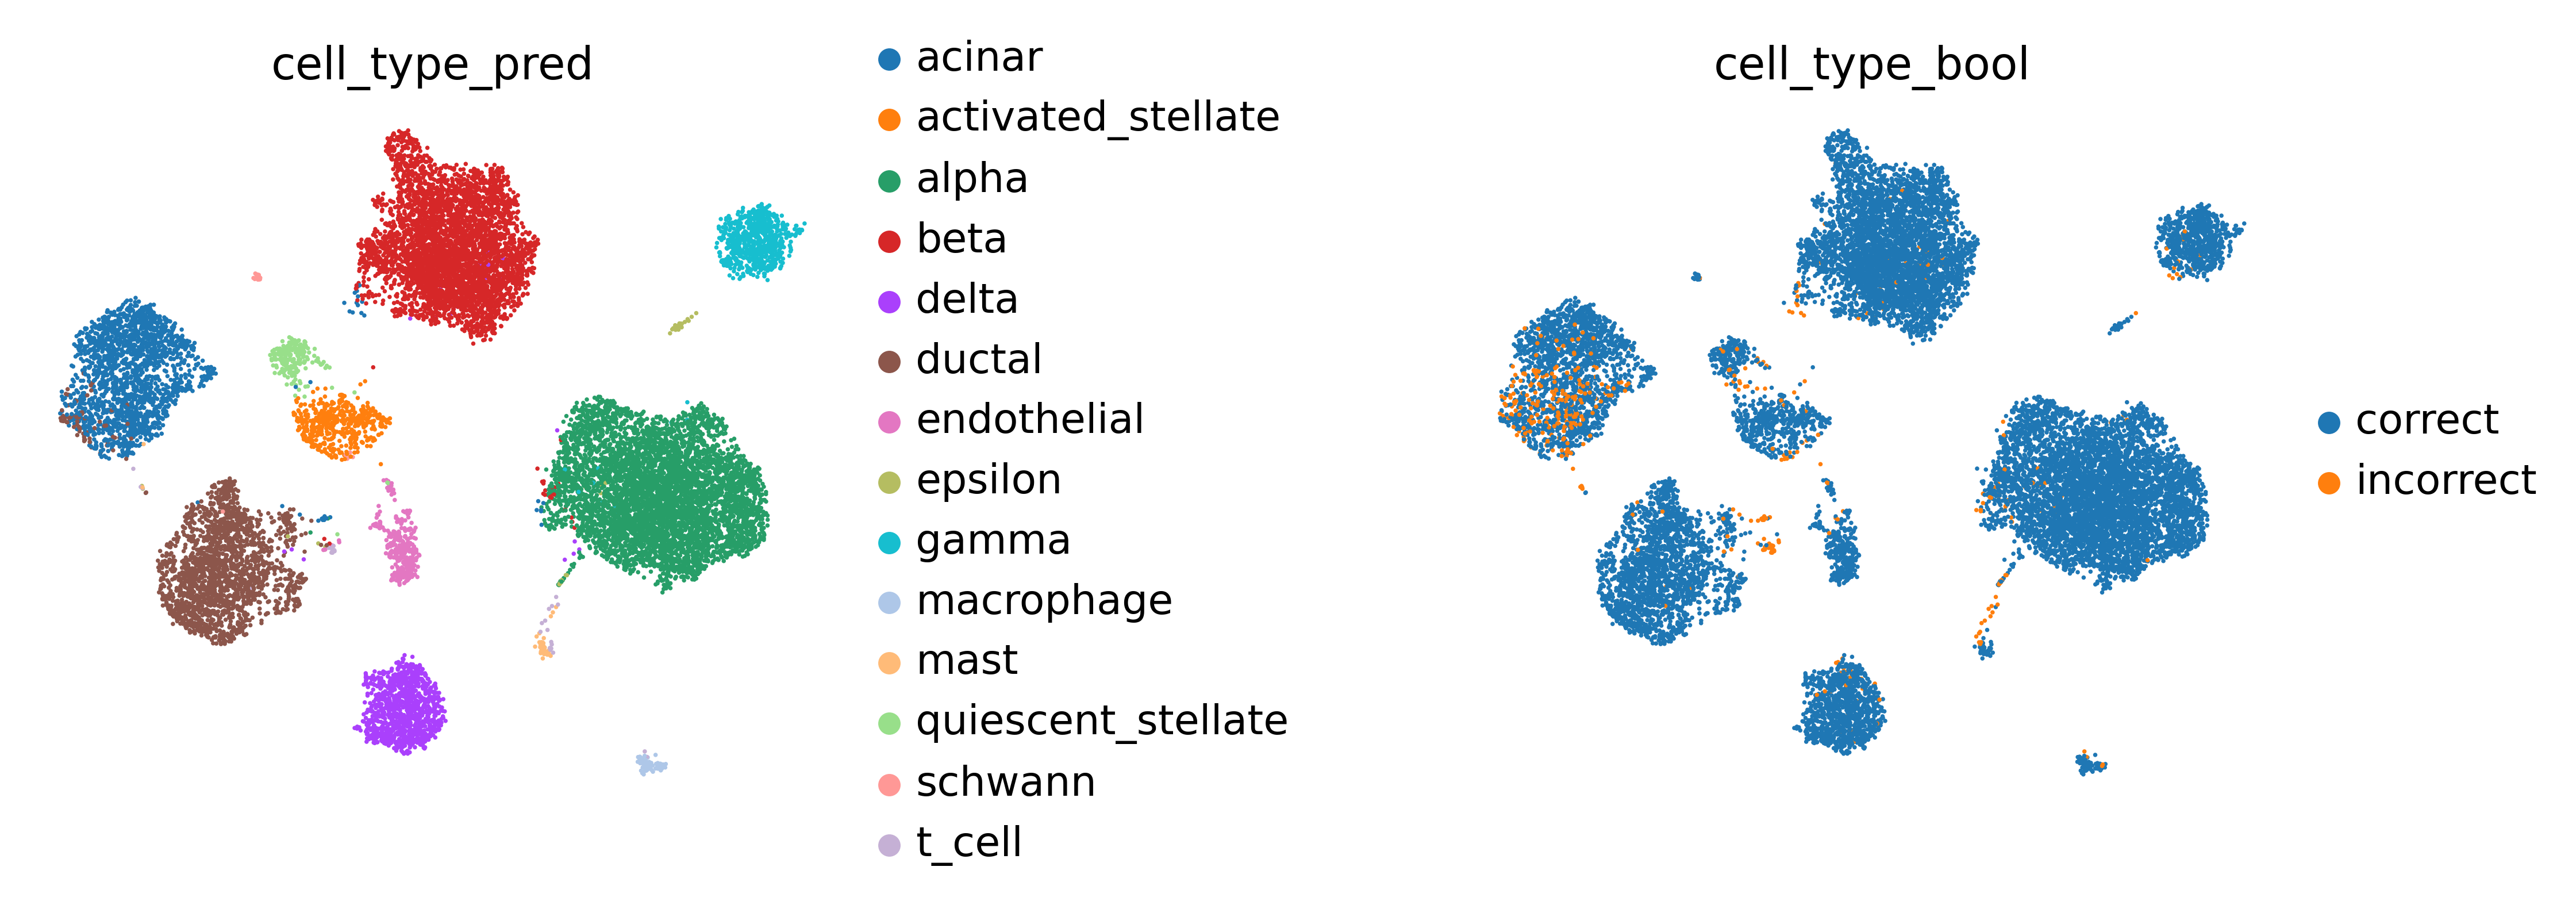

In [116]:
sc.pl.umap(
    adata_latent_wquery,
    color=['cell_type_pred', 'cell_type_bool'],
    wspace=0.6,
    frameon=False
)

In [132]:
f1 = list()
prec = list()
recall = list()
for key in list(results_dict['cell_type']['report'].keys())[:-4]:
    print(key)
    f1.append(results_dict['cell_type']['report'][key]['f1-score'])
    prec.append(results_dict['cell_type']['report'][key]['precision'])
    recall.append(results_dict['cell_type']['report'][key]['recall'])

acinar
activated_stellate
alpha
beta
delta
ductal
endothelial
epsilon
gamma
macrophage
mast
quiescent_stellate
schwann


/home/icb/carlo.dedonno/anaconda3/envs/lataq/lib/python3.8/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


Text(0.5, 1.0, 'F1 score')

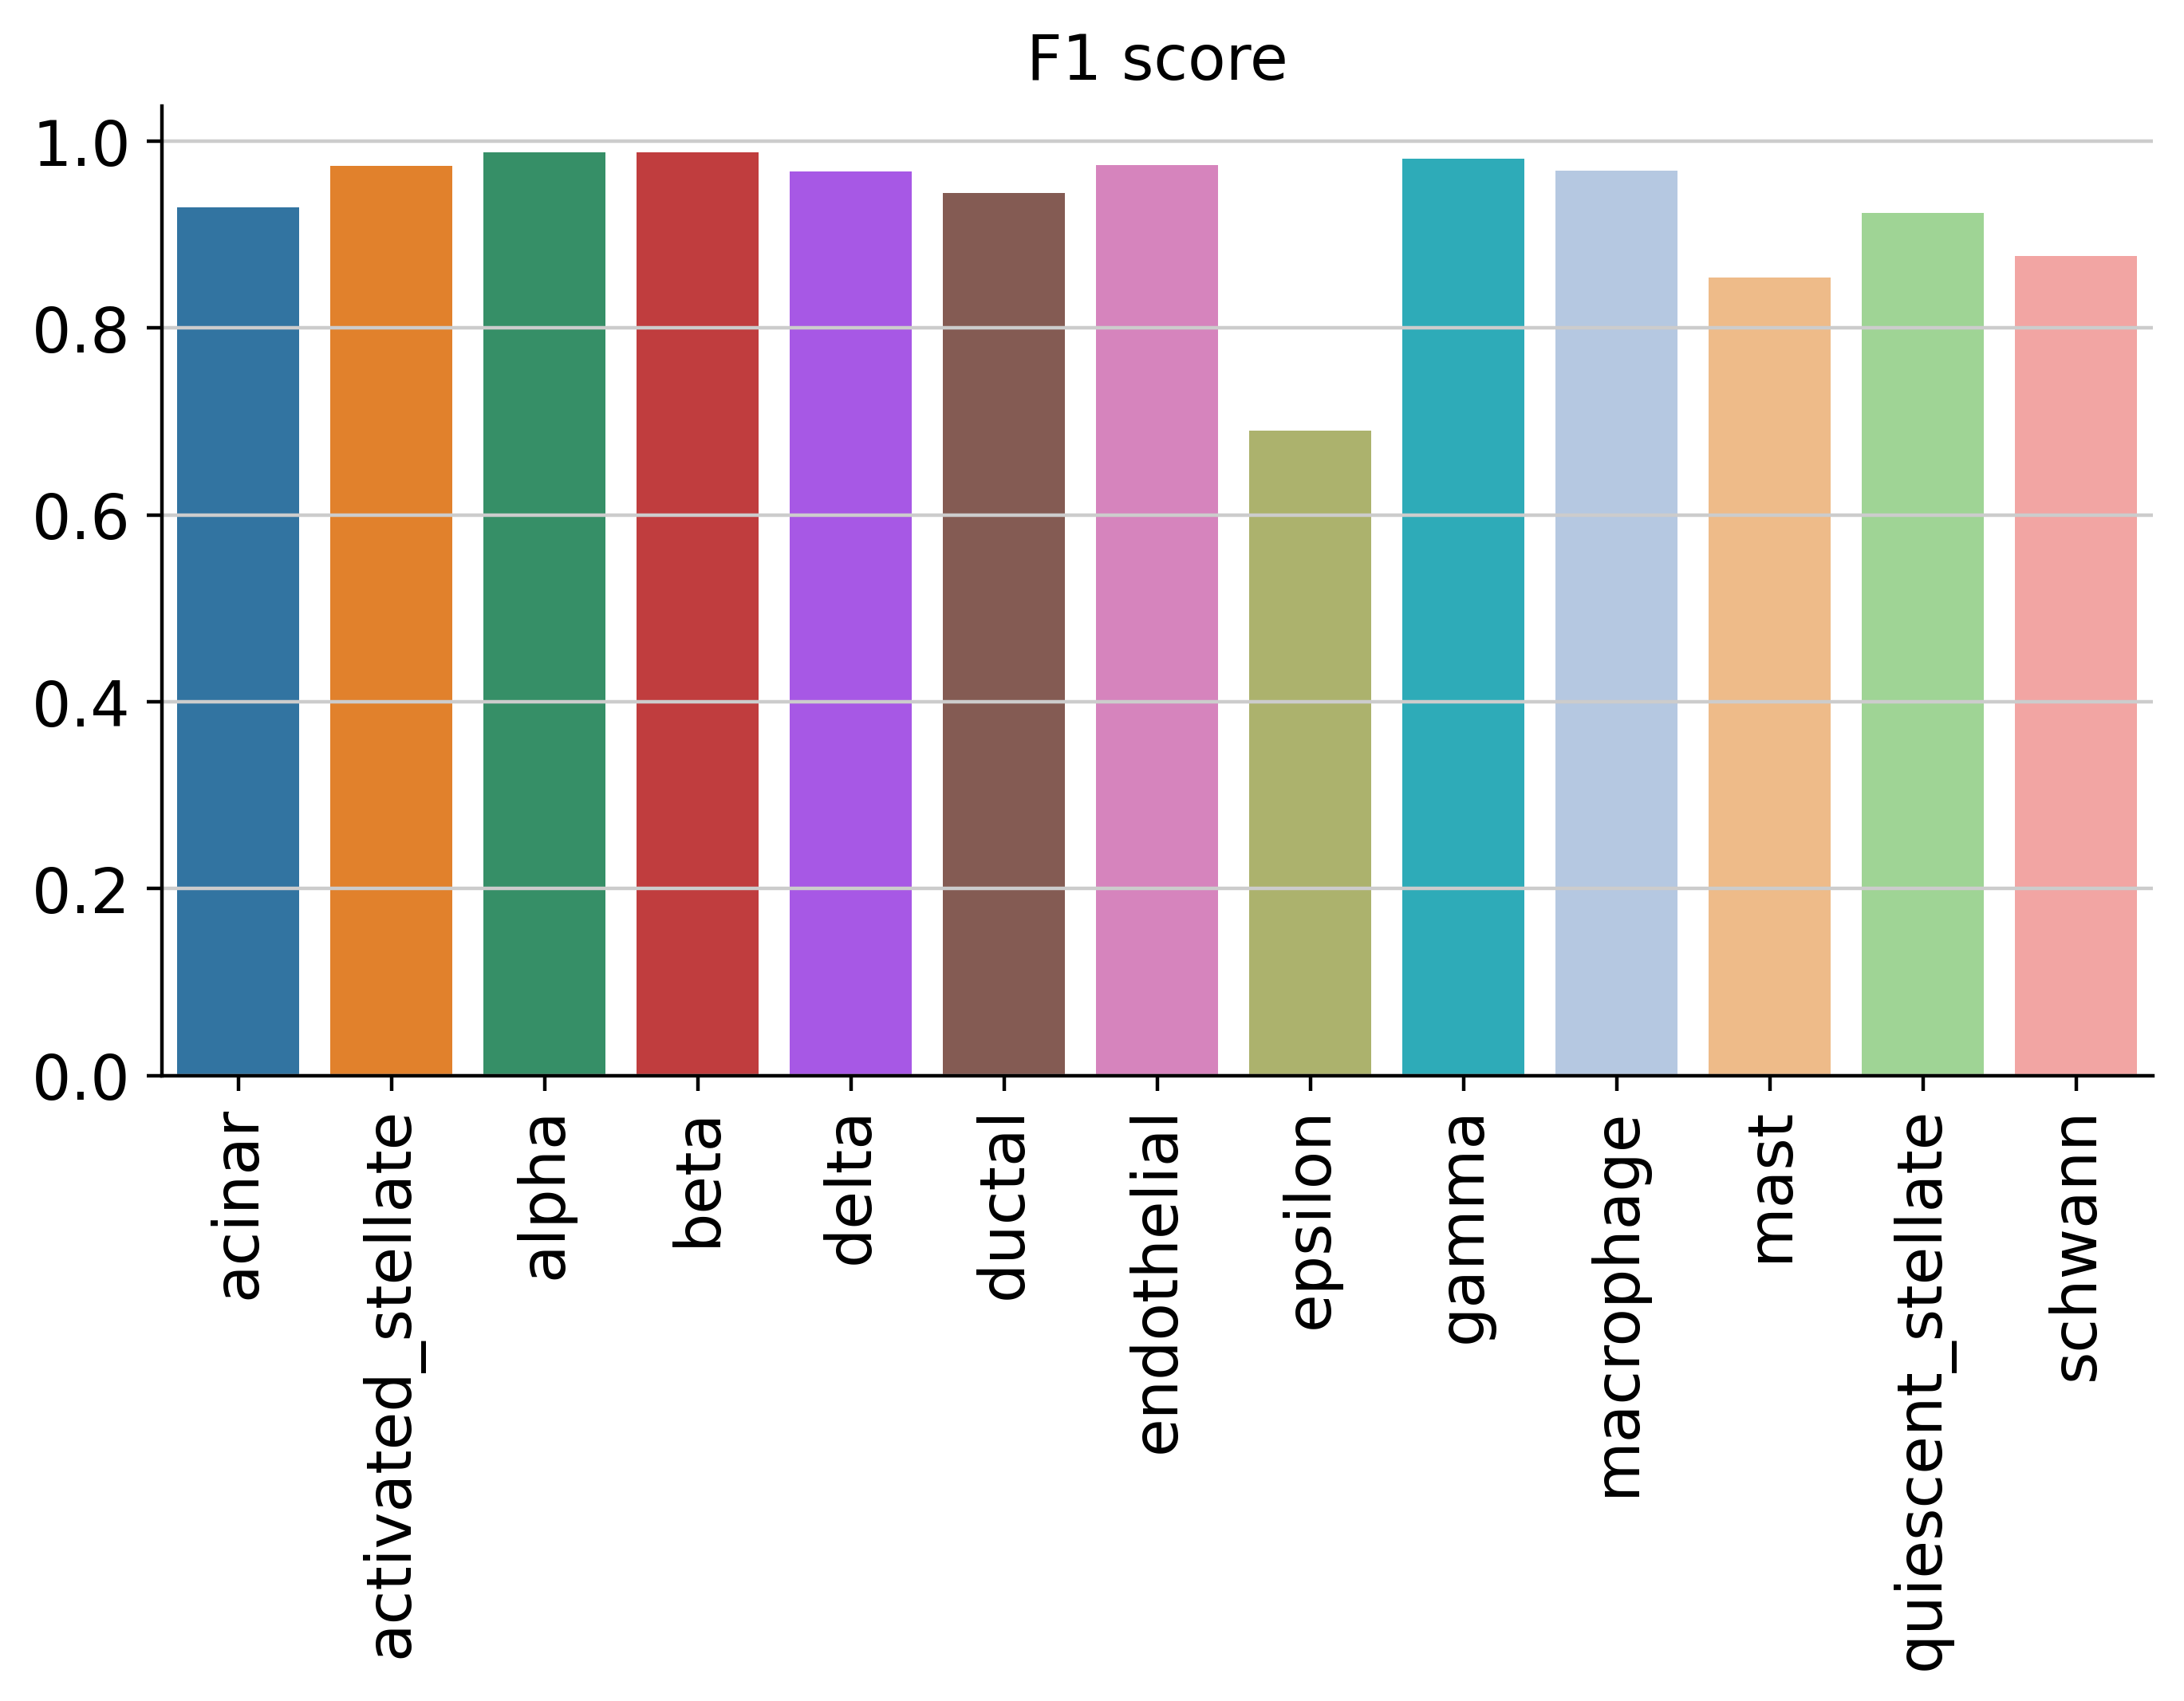

In [143]:
import seaborn as sns
fig, ax = plt.subplots(1, 1, figsize=(8, 4))
sns.barplot(
    list(results_dict['cell_type']['report'].keys())[:-4],
    f1,
)
ax.set_xticklabels(ax.get_xticklabels(), rotation=90)
sns.despine()
ax.set_title('F1 score')

/home/icb/carlo.dedonno/anaconda3/envs/lataq/lib/python3.8/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


Text(0.5, 1.0, 'precision')

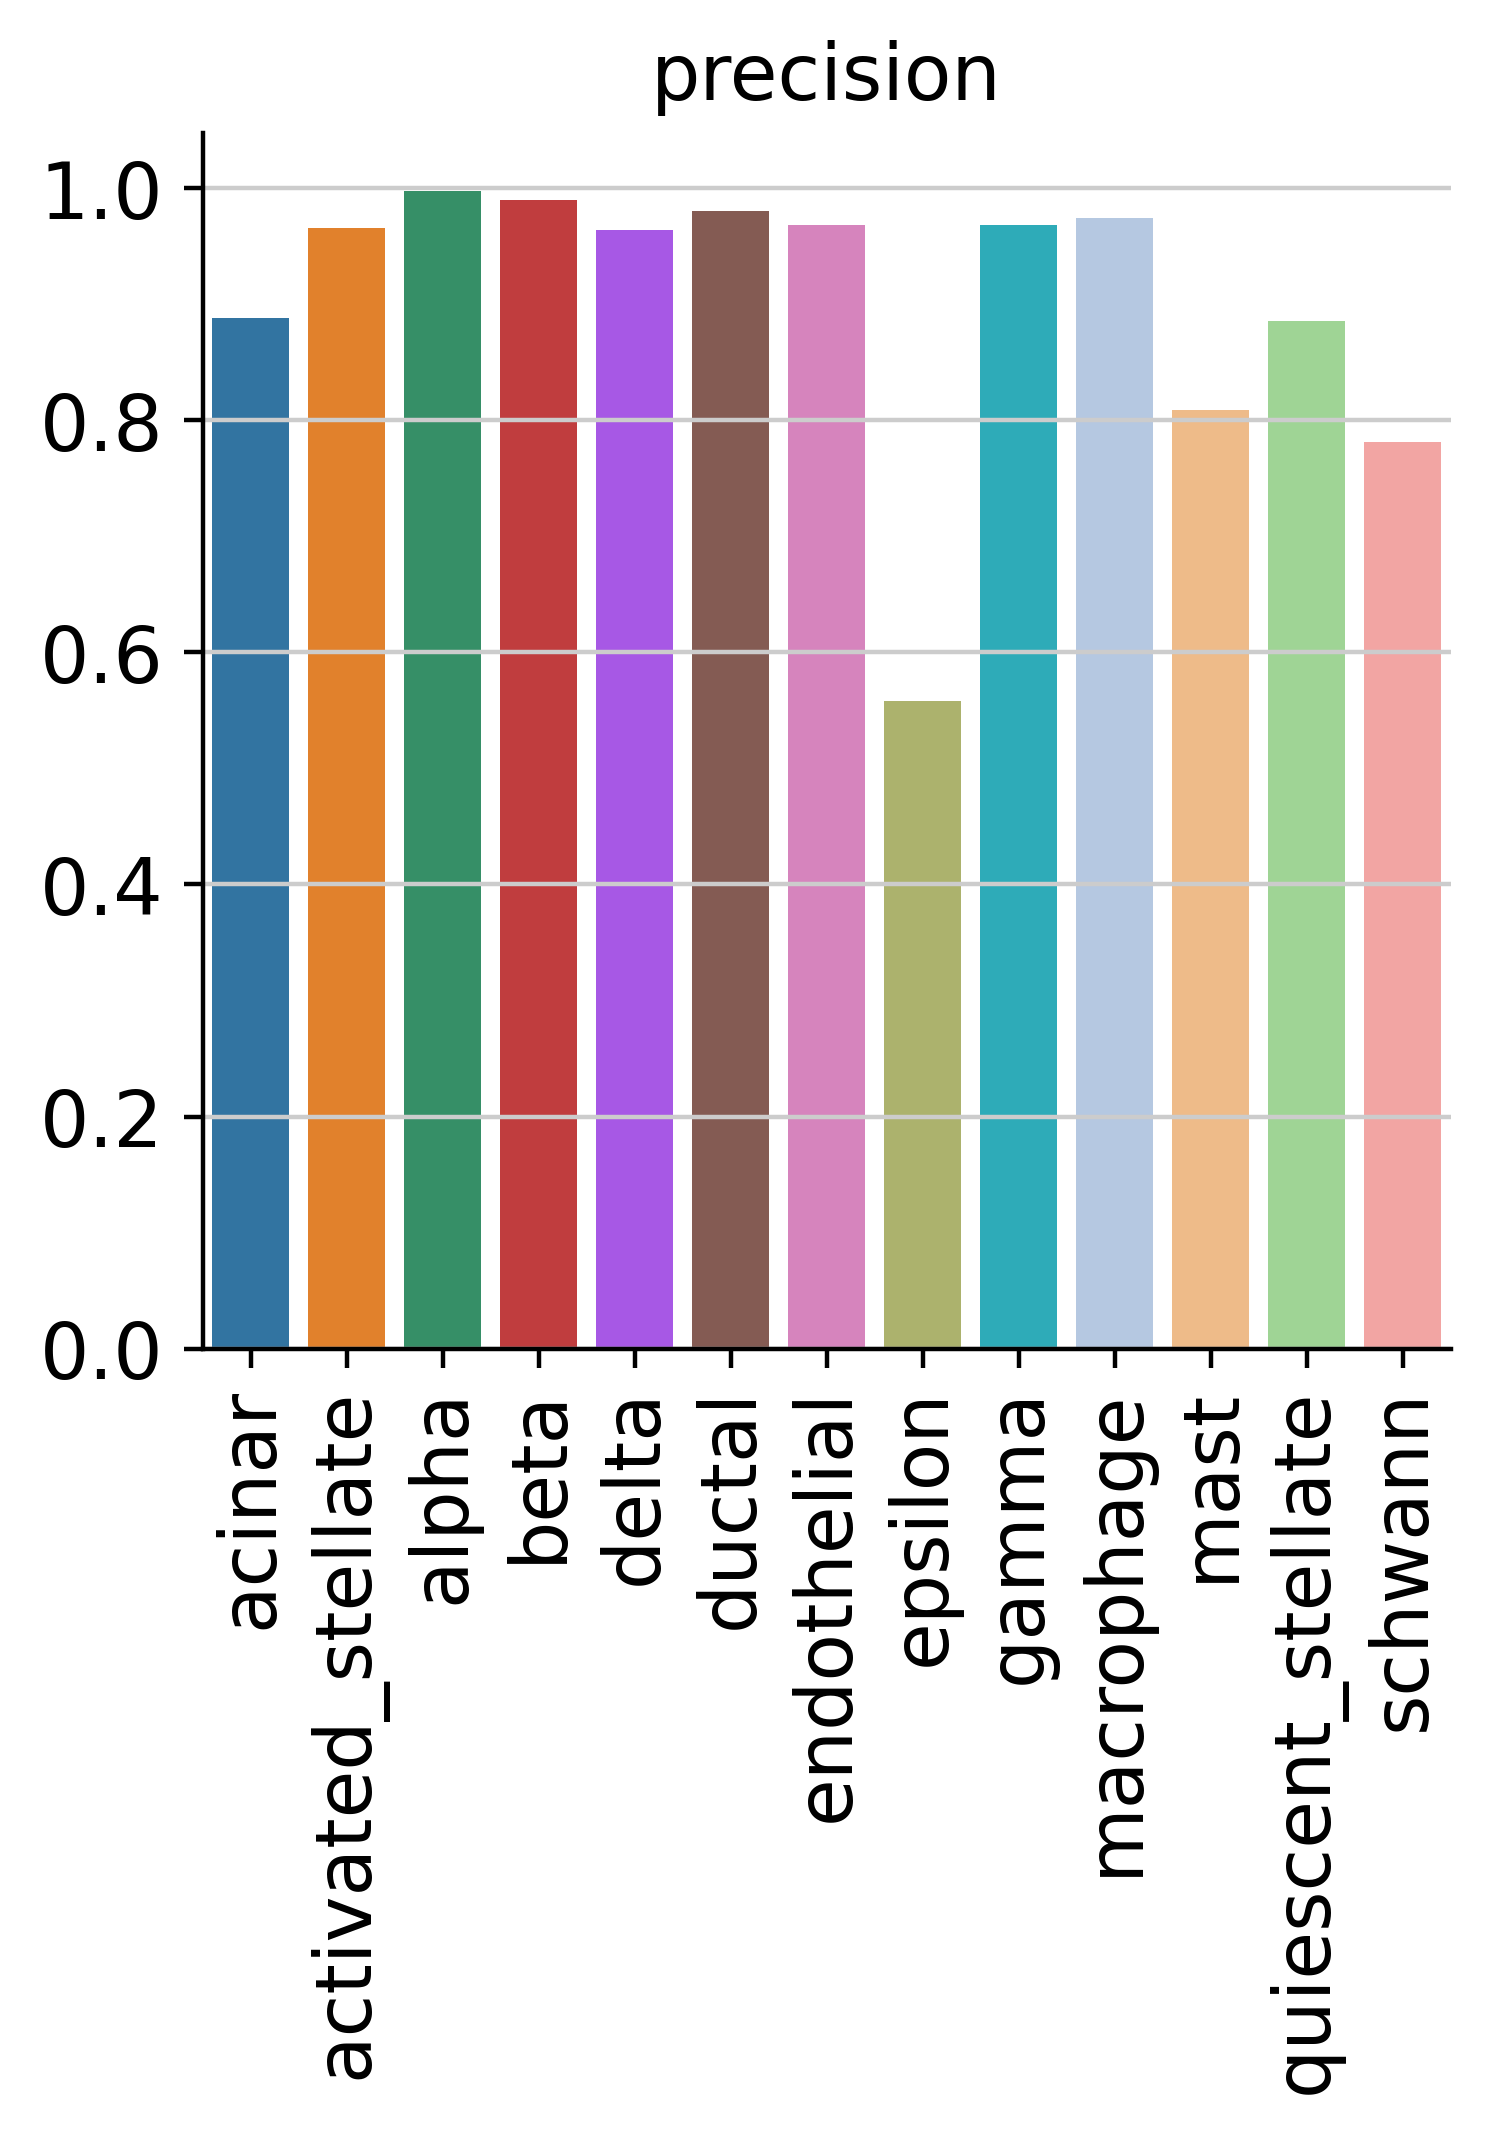

In [141]:
import seaborn as sns
fig, ax = plt.subplots(1, 1)
sns.barplot(
    list(results_dict['cell_type']['report'].keys())[:-4],
    prec,
)
ax.set_xticklabels(ax.get_xticklabels(), rotation=90)
sns.despine()
ax.set_title('precision')

/home/icb/carlo.dedonno/anaconda3/envs/lataq/lib/python3.8/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


Text(0.5, 1.0, 'recall')

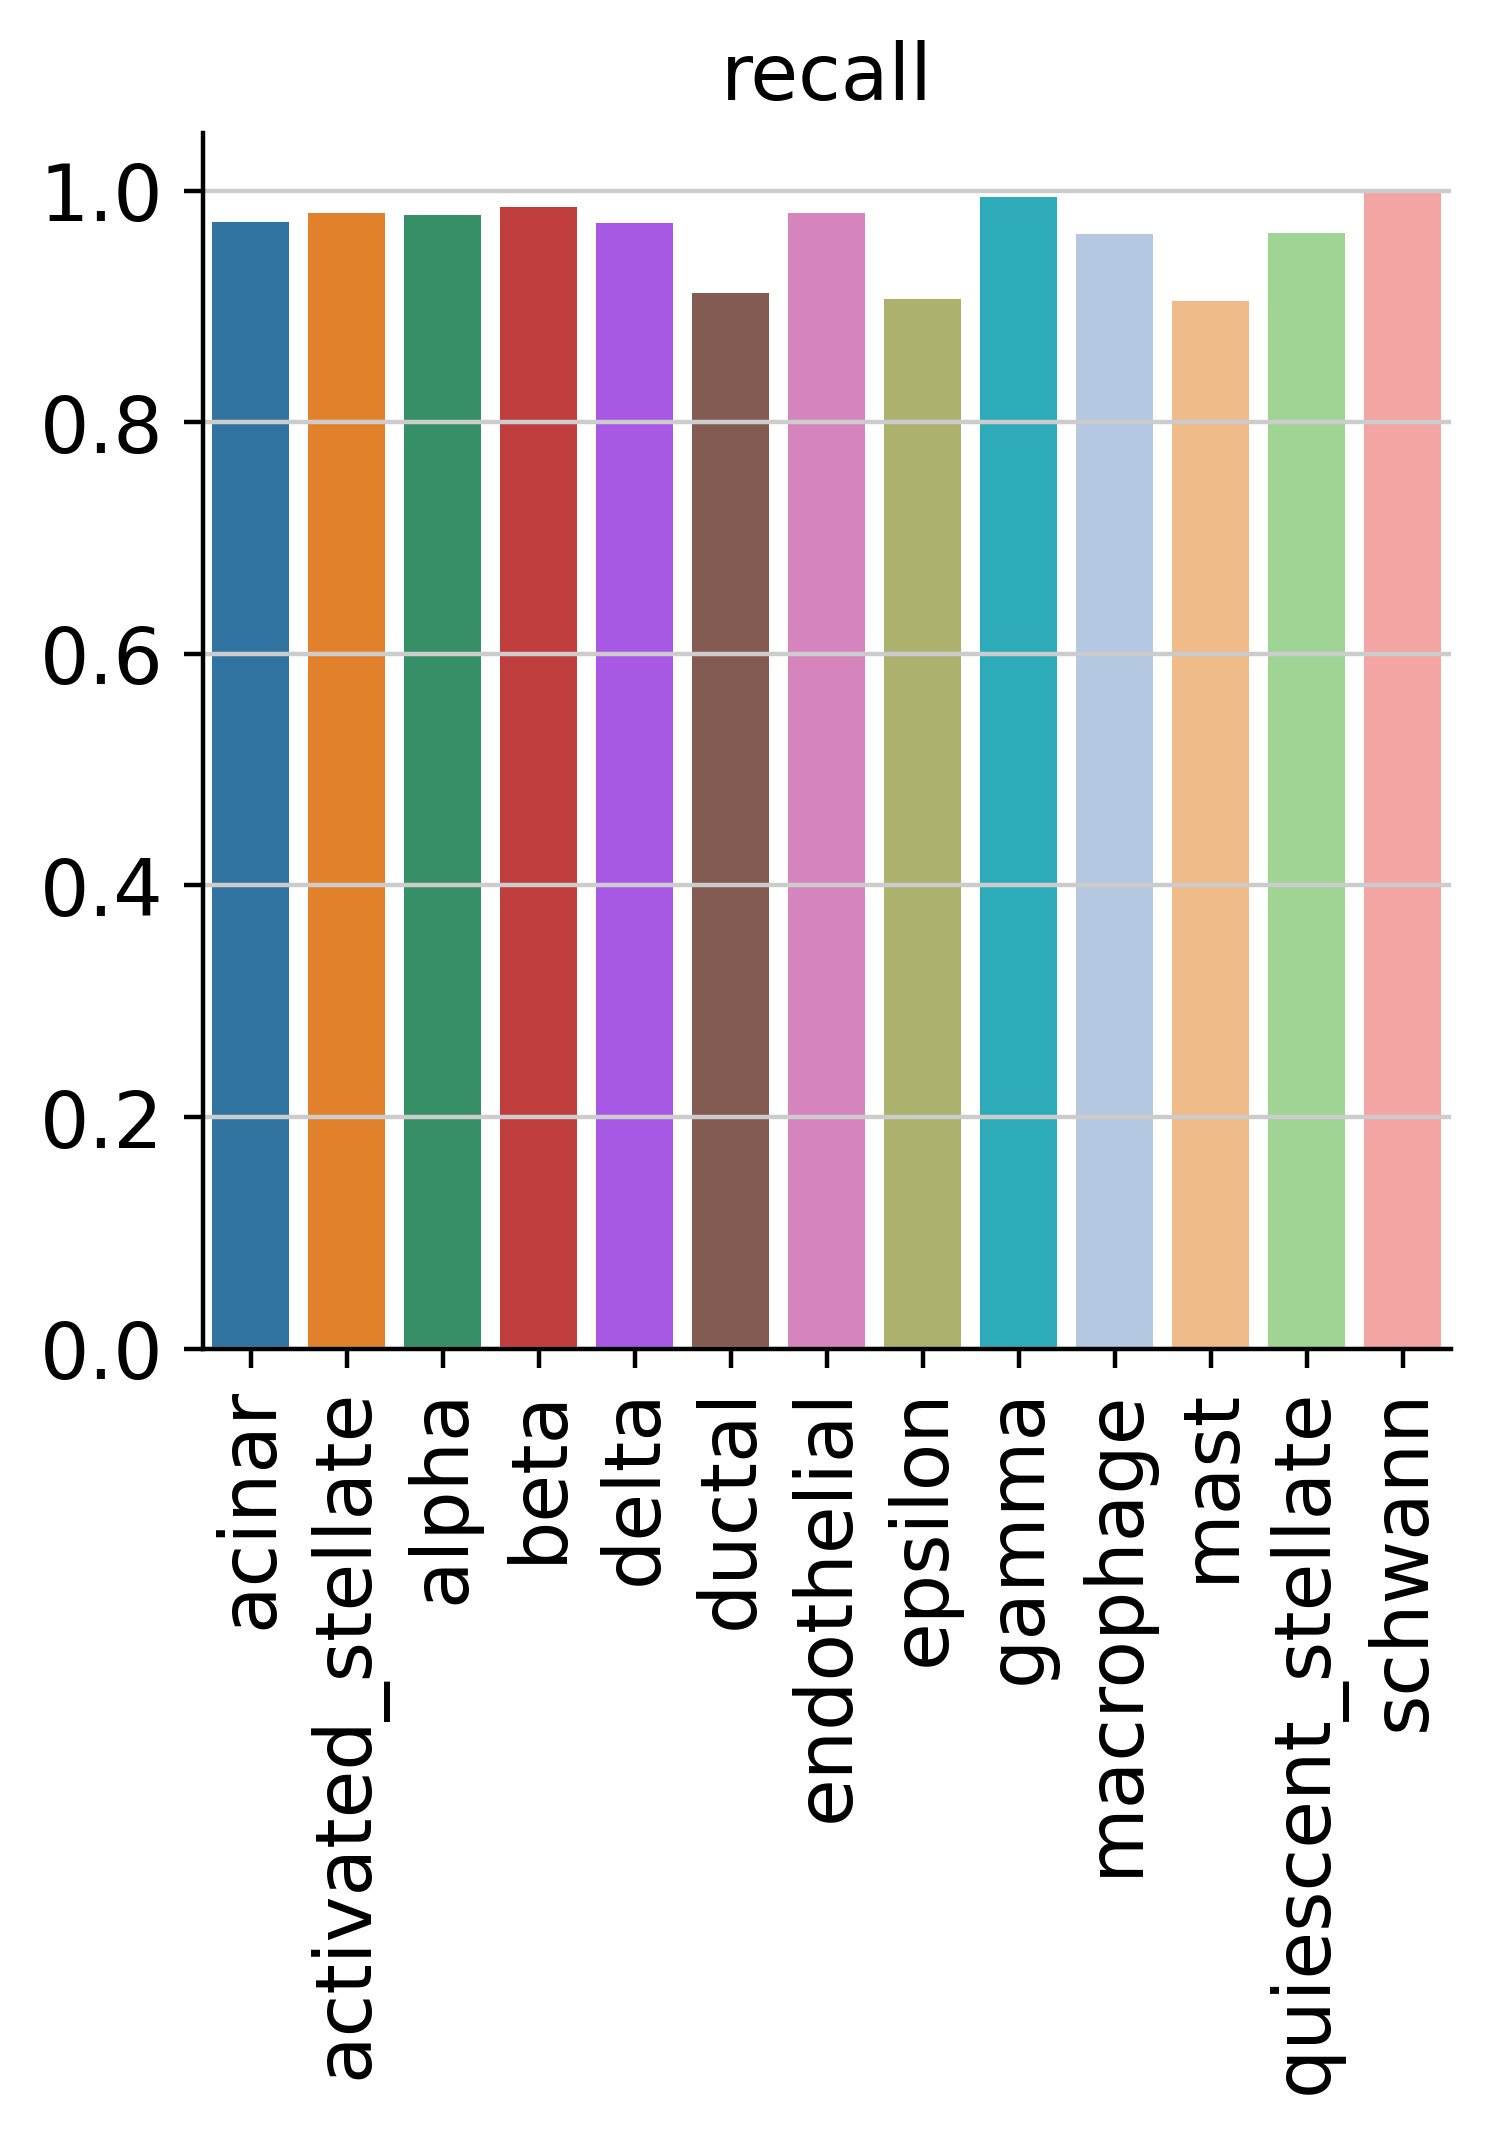

In [142]:
import seaborn as sns
fig, ax = plt.subplots(1, 1)
sns.barplot(
    list(results_dict['cell_type']['report'].keys())[:-4],
    recall,
)
ax.set_xticklabels(ax.get_xticklabels(), rotation=90)
sns.despine()
ax.set_title('recall')